In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
import matplotlib.pyplot as plt
sns.set()

### Using term frequency of n-grams across tv shows (with pre-defined vocabulary)

In [23]:
client = bigquery.Client()

query=f"""
select *
from goldenfleece.final_task.tv_1grams_monthly_bloomberg
order by DATE
"""
document_df = client.query(query).to_dataframe()
document_df.head(3)

,DATE,NGRAM,COUNT
0,2013-12-01,no,10.942748
1,2013-12-01,ass,1.600000
2,2013-12-01,bad,3.431818


In [24]:
document_df = document_df.astype({"DATE":"datetime64"}) 
document_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403901 entries, 0 to 403900
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   DATE    403901 non-null  datetime64[ns]
 1   NGRAM   403901 non-null  object        
 2   COUNT   403901 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 31.2 MB


In [25]:
document_df.DATE.describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  403901
unique                     85
top       2016-06-01 00:00:00
freq                     5000
first     2013-12-01 00:00:00
last      2020-12-01 00:00:00
Name: DATE, dtype: object

In [26]:
tf_df = pd.pivot_table(document_df, values="COUNT", index="DATE", columns="NGRAM", aggfunc=np.mean, fill_value=0)

In [27]:
tf_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85 entries, 2013-12-01 to 2020-12-01
Columns: 6941 entries, 144a to zone
dtypes: float64(6007), int64(934)
memory usage: 4.5 MB


In [28]:
query="""
-- join gdp, inflation, unemployment table
select a.date as DATE, a.cpi as CPI, b.unemployment AS UNEMPLOYMENT, c.GDP from 
(select date, cpi from goldenfleece.final_task.target_cpi_all_items) a
inner join (select date, unemployment from goldenfleece.final_task.target_unemployment) b
on a.date = b.date
inner join (select DATE, GDP from goldenfleece.final_task.monthly_gdp_lag) c
on b.date = c.date
order by a.date
"""
target_df = client.query(query).to_dataframe()
target_df.head()

,DATE,CPI,UNEMPLOYMENT,GDP
0,2009-01-01,84.9,6.7,-2.0
1,2009-02-01,85.6,7.1,-1.5
2,2009-03-01,85.8,7.3,-1.6
3,2009-04-01,86.0,7.6,-1.1
4,2009-05-01,86.4,7.8,-1.0


In [29]:
target_df = target_df.astype({"DATE":"datetime64"}).set_index("DATE")
target_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2009-01-01 to 2020-08-01
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CPI           140 non-null    float64
 1   UNEMPLOYMENT  140 non-null    float64
 2   GDP           140 non-null    float64
dtypes: float64(3)
memory usage: 4.4 KB


In [47]:
# calculate month-on-month change
target_df["UNEMPLOYMENT_MOM_CHG"] = target_df["UNEMPLOYMENT"].diff()
target_df["CPI_MOM_CHG"] = target_df["CPI"].diff()

In [49]:
target_df = target_df.drop(columns=["CPI", "UNEMPLOYMENT"])
target_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2009-01-01 to 2020-08-01
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GDP                   140 non-null    float64
 1   UNEMPLOYMENT_MOM_CHG  139 non-null    float64
 2   CPI_MOM_CHG           139 non-null    float64
dtypes: float64(3)
memory usage: 9.4 KB


In [50]:
# reset index to set DATE as column
combined_df = tf_df.merge(target_df, left_index=True, right_index=True, how="inner").reset_index()
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Columns: 6945 entries, DATE to CPI_MOM_CHG
dtypes: datetime64[ns](1), float64(6010), int64(934)
memory usage: 4.3 MB


In [51]:
combined_df.DATE.describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                      81
unique                     81
top       2016-05-01 00:00:00
freq                        1
first     2013-12-01 00:00:00
last      2020-08-01 00:00:00
Name: DATE, dtype: object

In [35]:
from cross_validate import cross_validate, build_design_matrix, evaluate_features

### Check stationarity assumption

From visual inspection, exclude COVID period to satisfy stationarity assumption

### Target: 3M on 3M GDP Change

In [54]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

estimator=LinearRegression()
# estimator=Ridge()
# estimator=Lasso()
# estimator=DecisionTreeRegressor(random_state=0)
# estimator=RandomForestRegressor(random_state=0)

results_df = pd.DataFrame()
for target_col in ["GDP", "CPI_MOM_CHG", "UNEMPLOYMENT_MOM_CHG"]:
    print(f"Forecast for {target_col}:")
    rmse_list = []
    design_df_list = []
    result_df_list = []
    for horizon in [1,2,3,4,5,6]:
        design_df, result_df = evaluate_features(
             combined_df[tf_df.columns.tolist() + ["DATE", target_col]],
            date_col="DATE",
            var_col=target_col,
            horizon=horizon,
            estimator=estimator,
            window=36,
            period=1,
            return_model=True,
            start_date="2013-12-01",
            end_date="2020-08-01",
        )
        # add metadata to result_df     
        result_df["horizon"] = horizon
        result_df["target"] = target_col
        rmse = (((result_df["pred"] - result_df["actual"]) ** 2).mean()) ** 0.5
        rmse_list.append(rmse)
        design_df_list.append(design_df)
        result_df_list.append(result_df)
        print(f"Average RMSE over {len(result_df)} predictions for {horizon}-month horizon: {rmse:.3f}")

    # concat the result_df_list for different targets
    results_df = pd.concat(result_df_list + [results_df])
    print(f"\nAverage RMSE across different horizons: {np.array(rmse_list).mean():.3f}\n")

Forecast for GDP:
Average RMSE over 42 predictions for 1-month horizon: 5.092
Average RMSE over 40 predictions for 2-month horizon: 5.203
Average RMSE over 38 predictions for 3-month horizon: 5.292
Average RMSE over 36 predictions for 4-month horizon: 5.305
Average RMSE over 34 predictions for 5-month horizon: 5.474
Average RMSE over 32 predictions for 6-month horizon: 5.664

Average RMSE across different horizons: 5.338

Forecast for CPI_MOM_CHG:
Average RMSE over 42 predictions for 1-month horizon: 0.298
Average RMSE over 40 predictions for 2-month horizon: 0.320
Average RMSE over 38 predictions for 3-month horizon: 0.308
Average RMSE over 36 predictions for 4-month horizon: 0.311
Average RMSE over 34 predictions for 5-month horizon: 0.292
Average RMSE over 32 predictions for 6-month horizon: 0.348

Average RMSE across different horizons: 0.313

Forecast for UNEMPLOYMENT_MOM_CHG:
Average RMSE over 42 predictions for 1-month horizon: 0.097
Average RMSE over 40 predictions for 2-month 

<AxesSubplot:xlabel='date', ylabel='3M on 3M GDP Change'>

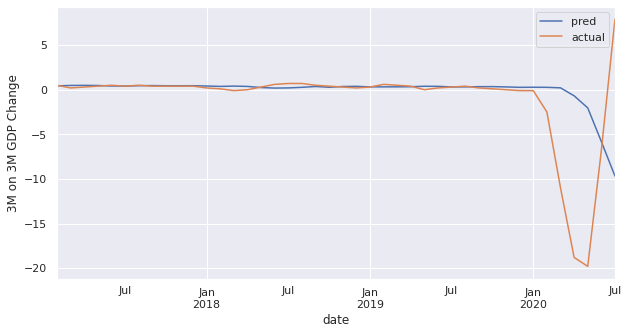

In [55]:
# check GDP 1-month horizon plot for 
gdp_result_df = results_df.loc[(results_df["target"] == "GDP") & (results_df["horizon"] == 1)]
gdp_result_df[["pred", "actual", "date"]].set_index("date").plot(figsize=(10,5), ylabel="3M on 3M GDP Change")

In [57]:
results_df.to_csv("model_result.csv", index=False)